# Color Correction Exercises
## _Imagerie Couleur_
## Ricardo Sapaico
## 2021/09/16
----

### Import necessary Libraries

In [1]:
import os

import colour
import colour_checker_detection
import imageio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### Load Image

Image Size:  (3264, 4912, 3)


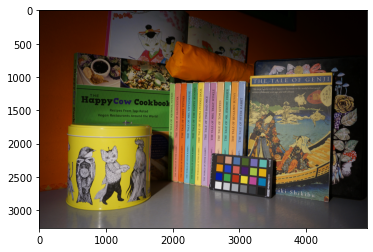

In [2]:
# Input/Output
filepath = r"C:\Users\Ricardo\Documents\Working\EPITA\2021\ColorChecker_at_Home\JPEG"
filename = "DSC00232.JPG"
outpath = r"C:\Users\Ricardo\Documents\Working\EPITA\2021\TP_02\Color_Correction"

# Load Input Image
img = imageio.imread(os.path.join(filepath, filename))
print("Image Size: ", img.shape)
plt.imshow(img)

### Get the position of ColorChecker in the image

Number of ColorChecker charts detected:  1
[[ 3380.41111111  2776.64444444]
 [ 2609.5         2705.01111111]
 [ 2660.66666667  2159.23333333]
 [ 3431.57777778  2227.45555556]]


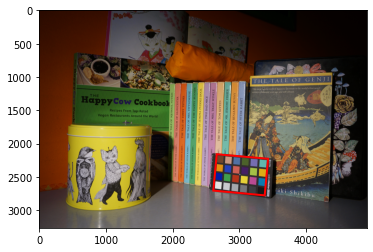

In [3]:
cc_position_scaled = colour_checker_detection.colour_checkers_coordinates_segmentation(img)
# scale factor (library resizes the image to a width of 1440)
scale_factor = img.shape[1]/1440
# get number of ColorChecker charts that were found (it should be 1)
cc_count = len(cc_position_scaled)
print("Number of ColorChecker charts detected: ", cc_count)
if (cc_count>0):
    # get the position of the ColorChecker chart in the original image
    # work with the data of the first ColorChecker detected
    cc_position = scale_factor * cc_position_scaled[0]
    # corner order in result: Bottom-Left, Top-Left, Top-Right, Bottom-Right
    print(cc_position)
    # draw detected colorchecker on the image
    fig, ax = plt.subplots()
    ax.imshow(img)
    poly = plt.Polygon(cc_position, linewidth=2, ec="r", facecolor='none')
    ax.add_patch(poly)
    plt.show()

### Get masks for each patch in the ColorChecker

Number of ColorChecker charts detected:  1
Number of patches in ColorChecker chart:  24


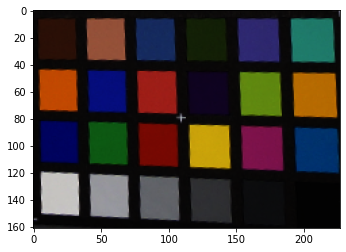

In [4]:
# Sample Size is the size of a small square area in the center of each color patch
# It needs to be adjusted according to the ColorChecker size (Larger ColorChecker -> Larger Sample Size)
# Set additional_data to True to get masks and segmented ColorChecker image
sample_size_rectangle = 12
cc_data = colour_checker_detection.detect_colour_checkers_segmentation(img, samples=sample_size_rectangle,
                                                                       additional_data=True)
cc_count = len(cc_data)
print("Number of ColorChecker charts detected: ", cc_count)
if (cc_count>0):
    # Get the RGB values of patches
    # It seems there's a bug and it returns BGR, so convert to RGB
    patch_colors=cc_data[0].swatch_colours
    patch_colors_fixed = patch_colors[:,[2,1,0]]
    # Get the detected ColorChecker image
    # It seems there's a bug and it returns a BGR image, so convert to RGB
    color_checker_img=cc_data[0].colour_checker_image
    color_checker_img_fixed = color_checker_img[:,:,[2,1,0]]
    # Get masks of the first ColorChecker chart
    # Each line contains: x_start:x_end,y_start:y_end
    # Positions are relative to the detected chart position
    patch_position_in_cc = cc_data[0].swatch_masks
    patch_count = len(patch_position_in_cc)
    print("Number of patches in ColorChecker chart: ", patch_count)
    plt.imshow(color_checker_img_fixed)

### Extract Fitted ColorChecker Image
#### The functions detects the ColorChecker and if it's rotated, it straightens it

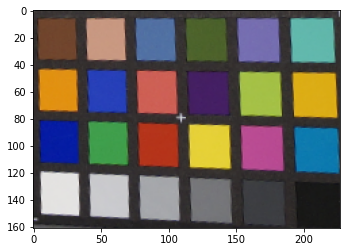

In [12]:
# This function is called inside "detect_colour_checkers_segmentation"
# But because the RGB values have been modified (I don't understand why or how),
# we need to extract the color checker image manually
cc_images = colour_checker_detection.extract_colour_checkers_segmentation(img)
cc_image = cc_images[0]
plt.imshow(cc_image)

### Extract the mean RGB value in each color patch, and normalize them

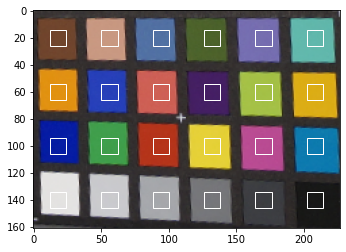

In [13]:
patch_mean_rgb = []
fig, ax = plt.subplots(1)
ax.imshow(cc_image)
for patch_position in patch_position_in_cc:
    # Get center area of patch (size should be equal to "Sample Size" variable above)
    patch = cc_image[patch_position[0]:patch_position[1],
                    patch_position[2]:patch_position[3]]
    patch_mean_rgb.append(np.mean(patch, axis=(0, 1)))
    # Create a Rectangle patch to be drawn
    rect = patches.Rectangle((patch_position[2], patch_position[0]), \
                             patch_position[3] - patch_position[2], \
                             patch_position[1] - patch_position[0], \
                             linewidth=1, edgecolor='w', facecolor='none')
    ax.add_patch(rect)
# Normalize the RGB values between 0 and 1
patch_mean_rgb_norm = np.asarray(patch_mean_rgb) / 255.0  # shape: [m x 3]
# Save normalized RGB mean results to file
np.savetxt(os.path.join(outpath,"rgb_mean_norm_colors.csv"), patch_mean_rgb_norm, fmt="%f", delimiter=",")

### Linearize RGB values
A Non-Linear Function was applied to RGB values when the JPEG file was created.\
Calibration won't work well if we use non-linear RGB values!\
Here we apply a **simplified** version

In [14]:
# Gamma used in sRGB is approx. 2.2
gamma = 2.2
patch_mean_rgb_norm_linearized = patch_mean_rgb_norm ** gamma
# Save normalized RGB mean results to file
np.savetxt(os.path.join(outpath,"rgb_mean_norm_linear_colors.csv"), patch_mean_rgb_norm_linearized, fmt="%f", delimiter=",")

### Small Pause
#### We have segmented two ColorCharts and obtained two sets of mean RGB values:
1. One computed automatically by the library
2. One computed by us

#### Now we will compare the RGB values
#### Our hypothesis is that, even if they are different, "colors" should be the same. Therefore, "Hue" should be similar.
#### Let's check it out using the following website (open it twice):
__[http://colorizer.org/](http://colorizer.org/)__

In [ ]:
# Convert Average RGB values computed by the Library to HSV
hsv_library = [colour.RGB_to_HSV(p) for p in patch_colors_fixed]

# Convert Average RGB values computed by us to HSV
hsv_us = [colour.RGB_to_HSV(p) for p in patch_mean_rgb]

# Check Hue of patch colors
print("Hue values of all patches")
for idx,(lib,us) in enumerate(zip(hsv_library,hsv_us)):
    print("Patch #{:02d}: Lib={:.4f} Us={:.4f} Diff={:.4f}".format(idx,lib[0],us[0],np.abs(lib[0]-us[0])))

# Print RGB values of first 6 patches
print("RGB values of first 6 patches")
for p in range(6):
    print("Library: ",(255*patch_colors_fixed[p]).astype(np.uint8))
    print("Us     : ",patch_mean_rgb[p].astype(np.uint8))

### Get Reference XYZ and Lab Data of ColorChecker Chart
We need to pay attention that the XYZ data is given with a D65 illuminant\
As this is the same illuminant of the sRGB values used for the color correction

In [15]:
# Get reference xyY chromaticy coordinates for the ColorChecker Chart
# xyY values correspond to a D50 illuminant
cc_xyY_reference = colour.CCS_COLOURCHECKERS['ColorChecker24 - After November 2014']
# Convert all values from xyY to XYZ
cc_XYZ_reference = colour.xyY_to_XYZ(list(cc_xyY_reference.data.values()))
# Chromatic Adaptation of XYZ values as their illuminant was D50
bradford_d50_to_d65 = np.array([ [ 0.9555766, -0.0230393, 0.0631636],
                                 [-0.0282895,  1.0099416, 0.0210077],
                                 [ 0.0122982, -0.0204830, 1.3299098] ])
cc_XYZ_reference_d65 = bradford_d50_to_d65.dot(cc_XYZ_reference.transpose()).transpose()  # output shape: [m x 3]
# Compute the Lab values under D65 illuminant
illum_D65 = colour.CCS_ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D65']
cc_Lab_reference = colour.XYZ_to_Lab(cc_XYZ_reference_d65, illum_D65)  # shape: [m x 3]
# Save XYZ and Lab reference of ColorChecker to file
np.savetxt(os.path.join(outpath,"XYZ_reference_ccaft2014_D65.csv"), cc_XYZ_reference_d65, fmt="%f", delimiter=",")
np.savetxt(os.path.join(outpath,"Lab_reference_ccaft2014_D65.csv"), cc_Lab_reference, fmt="%f", delimiter=",")

### Let's just check one of the patches in the ColorChecker Chart
__[http://colorizer.org/](http://colorizer.org/)__

In [16]:
# Check for instance xyY, XYZ and Lab (D65) of "Foliage"
# Does it look correct to you?
xyY_foliage = cc_xyY_reference.data['foliage']
XYZ_foliage = colour.xyY_to_XYZ(xyY_foliage)
Lab_foliage = colour.XYZ_to_Lab(XYZ_foliage, illuminant=illum_D65)
print("Foliage:")
print("x={:.3f}, y={:.3f}, Y={:.3f}".format(xyY_foliage[0],xyY_foliage[1],xyY_foliage[2]))
print("X={:.3f}, Y={:.3f}, Z={:.3f}".format(XYZ_foliage[0],XYZ_foliage[1],XYZ_foliage[2]))
print("L={:.3f}, a={:.3f}, b={:.3f}".format(Lab_foliage[0],Lab_foliage[1],Lab_foliage[2]))

Foliage:
x=0.373, y=0.451, Y=0.135
X=0.111, Y=0.135, Z=0.052
L=43.460, a=-11.572, b=29.778


## Color Correction
### If you remember, the equation we need to solve is: $X=MP$, and its solution is: $M=XP^T(PP^T)^{-1}$
### where:
- X shape = 3 x m (m is number of Reference points)
- M shape = 3 x N (N depends on the correction method)
- P shape = N x m

$m = 24$ because we are using the ColorChecker Chart

### Get X matrix (Reference XYZ information) in the expected shape

In [17]:
X = cc_XYZ_reference_d65.transpose()  # shape: [3 x m]
print(X.shape)

(3, 24)


### Get a Matrix containing all image pixels, normalized and linearized

In [18]:
img_all_rgb_values = (img.reshape(-1, img.shape[-1])).transpose()  # shape: [3 x Width*Height]
print(img_all_rgb_values.shape)
#### ADD CODE FOR NORMALIZING AND LINEARIZING THE ENTIRE IMAGE ####
# Normalizing = Set Range between [0,1]
# Linearizing = Unapplying the Gamma Curve
img_all_rgb_values_norm_linearized = (img_all_rgb_values / 255.0) ** gamma

(3, 16032768)


### LINEAR CORRECTION
#### In this case, N=3

In [ ]:
# Get P
P_linear = patch_mean_rgb_norm_linearized.transpose()  # shape: [3 x 24]
# Solve equation (compute M from X and P)
t1 = P_linear.dot(P_linear.transpose())
t2 = np.linalg.inv(t1)
t3 = (P_linear.transpose()).dot(t2)
M_linear = X.dot(t3)  # correction matrix, shape: [3 x 3]
# Save correction matrix to file
print(M_linear)
np.savetxt(os.path.join(outpath,"CorrMatrix_Linear.csv"), M_linear, fmt="%f", delimiter=",")

#### Use Correction to Predict XYZ corrected data for the entire image
##### It might take a while if image is Large!

In [ ]:
# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected = M_linear.dot(img_all_rgb_values_norm_linearized)  # shape: [3 x Width*Height]
# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([ [ 3.2404542,-1.5371385,-0.4985314],
                                [-0.9692660, 1.8760108, 0.0415560],
                                [ 0.0556434,-0.2040259, 1.0572252] ])
img_RGB_values_from_XYZ = matrix_XYZ_to_sRGB.dot(img_XYZ_values_corrected)
# Apply simplified gamma inverse
img_RGB_values_corrected = img_RGB_values_from_XYZ ** (1/gamma)
# Rescale to 0..255
img_RGB_linear = 255 * img_RGB_values_corrected
# Clip the values in case there are unexpected values
img_RGB_linear[img_RGB_linear < 0] = 0  
img_RGB_linear[img_RGB_linear > 255] = 255
# Convert to uint8
img_RGB_linear_uint8 = img_RGB_linear.astype(np.uint8)
# Reshape to [Width x Height x 3]
img_RGB_linear_reshaped = img_RGB_linear_uint8.transpose().reshape((img.shape[0], img.shape[1], -1))
print(img_RGB_linear_reshaped.shape)
imageio.imwrite(os.path.join(outpath,'image_corrected_Linear.jpg'), img_RGB_linear_reshaped)

#### Use Correction to Predict XYZ corrected data for the 24 Patches of the ColorChecker Chart

In [ ]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_linear = M_linear.dot(P_linear)  # shape: [3 x 24]
# Convert to Lab
cc_Lab_corrected_linear = colour.XYZ_to_Lab(cc_XYZ_corrected_linear.transpose(), illum_D65)  # shape: [24 x 3]
# Compute delta-E with reference XYZ data
cc_dE00_linear = colour.difference.delta_E_CIE2000(cc_Lab_reference, cc_Lab_corrected_linear)
# Show histogram of delta-E values
plt.hist(cc_dE00_linear, bins=20)
plt.title("Delta-E 2000 differences (Linear Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ",np.mean(cc_dE00_linear))
np.savetxt(os.path.join(outpath,"DeltaE2000_Linear.csv"), cc_dE00_linear, fmt="%f", delimiter=",")

### POLYNOMIAL (2ND DEGREE) CORRECTION

#### Compute Correction Matrix
#### In this case, N=9

In [ ]:
# Get P
# But before compute additional data: R^2, G^2, B^2, RG, RB, GB

P_poly2nd = ...  # shape: [9 x m]
# Solve equation and compute M

M_poly2nd = X.dot(  )  # correction matrix, shape: [3 x 9]
# Save correction matrix to file
print(M_poly2nd)
np.savetxt(os.path.join(outpath,"CorrMatrix_Poly2nd.csv"), M_poly2nd, fmt="%f", delimiter=",")

#### Apply Correction to Image

In [ ]:
# Generating extra rgb data (R^2, G^2, B^2, RG, RB, GB)
img_all_rgb_values_norm_linear_sq = img_all_rgb_values_norm_linearized ** 2
img_all_rgb_values_norm_linear_rgrbgb = np.vstack((img_all_rgb_values_norm_linearized[0, :] * img_all_rgb_values_norm_linearized[1, :],
                                                   img_all_rgb_values_norm_linearized[0, :] * img_all_rgb_values_norm_linearized[2, :],
                                                   img_all_rgb_values_norm_linearized[1, :] * img_all_rgb_values_norm_linearized[2, :]))
img_all_rgb_values_norm_linear_poly2nd = np.concatenate(
    (img_all_rgb_values_norm_linearized, img_all_rgb_values_norm_linear_sq, img_all_rgb_values_norm_linear_rgrbgb))  # shape: [9 x Width*Height]
# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected_poly2nd = M_poly2nd.dot(img_all_rgb_values_norm_linear_poly2nd)  # shape: [3 x Width*Height]
# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([ [ 3.2404542,-1.5371385,-0.4985314],
                                [-0.9692660, 1.8760108, 0.0415560],
                                [ 0.0556434,-0.2040259, 1.0572252] ])
img_RGB_values_from_XYZ_poly2nd = matrix_XYZ_to_sRGB.dot(img_XYZ_values_corrected_poly2nd)
# Apply simplified gamma inverse
img_RGB_values_corrected_poly2nd = img_RGB_values_from_XYZ_poly2nd ** (1/gamma)
# Rescale to 0..255
img_RGB_poly2nd = 255 * img_RGB_values_corrected_poly2nd
# Clip the values in case there are unexpected values
img_RGB_poly2nd[img_RGB_poly2nd < 0] = 0  
img_RGB_poly2nd[img_RGB_poly2nd > 255] = 255
# Convert to uint8
img_RGB_uint8_poly2nd = img_RGB_poly2nd.astype(np.uint8)
# Reshape to [Width x Height x 3]
img_RGB_reshaped_poly2nd = img_RGB_uint8_poly2nd.transpose().reshape((img.shape[0], img.shape[1], -1))
print(img_RGB_reshaped_poly2nd.shape)
imageio.imwrite(os.path.join(outpath,'image_corrected_Poly2nd.jpg'), img_RGB_reshaped_poly2nd)

#### Predict Color of the ColorChecker and Compute Color Difference

In [ ]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_poly2nd = M_poly2nd.dot(P_poly2nd)  # shape: [3 x 24]
# Convert to Lab
cc_Lab_corrected_poly2nd = colour.XYZ_to_Lab(cc_XYZ_corrected_poly2nd.transpose(), illum_D65)  # shape: [24 x 3]
# Compute delta-E with reference XYZ data
cc_dE00_poly2nd = colour.difference.delta_E_CIE2000(cc_Lab_reference, cc_Lab_corrected_poly2nd)
# Show histogram of delta-E values
plt.hist(cc_dE00_poly2nd, bins=20)
plt.title("Delta-E 2000 differences (Polynomial Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ",np.mean(cc_dE00_poly2nd))
np.savetxt(os.path.join(outpath,"DeltaE2000_Polynomial.csv"), cc_dE00_poly2nd, fmt="%f", delimiter=",")

### Root Polynomial (2nd degree) Correction
#### In this case, N=6

In [ ]:
# Get P
# But before compute additional data: (RG)^0.5, (GB)^0.5, (RB)^0.5

P_root2nd = ...  # shape: [6 x m]
# Solve equation and compute M

M_root2nd = X.dot(  )  # correction matrix, shape: [3 x 6]
# Save correction matrix to file
print(M_root2nd)
np.savetxt(os.path.join(outpath,"CorrMatrix_Root2nd.csv"), M_root2nd, fmt="%f", delimiter=",")

#### Apply Correction to Image

In [ ]:
# Generating extra rgb data ((RG)^0.5, (GB)^0.5, (RB)^0.5)

img_all_rgb_values_norm_linear_root2nd = ...  # shape: [6 x Width*Height]
# Predict XYZ values (already in D65, same illuminant as sRGB)
img_XYZ_values_corrected_root2nd = ...  # shape: [3 x Width*Height]
# Convert from XYZ to sRGB
matrix_XYZ_to_sRGB = np.array([ [ 3.2404542,-1.5371385,-0.4985314],
                                [-0.9692660, 1.8760108, 0.0415560],
                                [ 0.0556434,-0.2040259, 1.0572252] ])
img_RGB_values_from_XYZ_root2nd = ...
# Apply simplified gamma inverse
img_RGB_values_corrected_root2nd = ...
# Rescale to 0..255
img_RGB_root2nd = 255 * img_RGB_values_corrected_root2nd
# Clip the values in case there are unexpected values
img_RGB_root2nd[img_RGB_root2nd < 0] = 0  
img_RGB_root2nd[img_RGB_root2nd > 255] = 255
# Convert to uint8
img_RGB_uint8_root2nd = img_RGB_root2nd.astype(np.uint8)
# Reshape to [Width x Height x 3]
img_RGB_reshaped_root2nd = img_RGB_uint8_root2nd.transpose().reshape((img.shape[0], img.shape[1], -1))
print(img_RGB_reshaped_root2nd.shape)
imageio.imwrite(os.path.join(outpath,'image_corrected_Root2nd.jpg'), img_RGB_reshaped_root2nd)

#### Predict Color of the ColorChecker and Compute Color Difference

In [ ]:
# Predict XYZ values (already in D65, same illuminant as Reference)
cc_XYZ_corrected_root2nd = ...  # shape: [3 x 24]
# Convert to Lab
cc_Lab_corrected_root2nd = ...  # shape: [24 x 3]
# Compute delta-E with reference XYZ data
cc_dE00_root2nd = ...
# Show histogram of delta-E values
plt.hist(cc_dE00_root2nd, bins=20)
plt.title("Delta-E 2000 differences (Root Polynomial Correction)")
plt.xlabel("delta-E values")
plt.ylabel("frequency")
print("Average delta-E 2000: ", np.mean(cc_dE00_root2nd))
np.savetxt(os.path.join(outpath,"DeltaE2000_RootPolynomial.csv"), cc_dE00_root2nd, fmt="%f", delimiter=",")